<a href="https://colab.research.google.com/github/nadiaSylla/Multi-class-prediction-of-Obesity-risk/blob/main/Final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
! pip install lightgbm
! pip install --upgrade lightgbm
! pip install catboost
!pip install optuna
import optuna
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostClassifier

from sklearn.model_selection import KFold
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from optuna.samplers import TPESampler
from sklearn.metrics import f1_score


# Load data

In [ ]:
file_path_train ='C:/Users/nadia/Downloads/kaggle challenge/train.csv'
file_path_test ='C:/Users/nadia/Downloads/kaggle challenge/test.csv'

dataTrain = pd.read_csv(file_path_train, sep=',', index_col ='id')
dataTest = pd.read_csv(file_path_test, sep=',', index_col ='id')

# Quick overview

In [ ]:
display('Train:', dataTrain.head())
display('Test:', dataTest.head())

'Train:'

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


'Test:'

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


Variables related to eating habit:

- FAVC: Frequent consumption of high caloric food
- FCVC: Frequency of consumption of vegetables
- NCP: Number of main meals
- CAEC: Consumption of food between meals
- CH20: Consumption of water daily
- CALC: Consumption of alcohol
- SCC: Calories consumption monitoring
- FAF: Physical activity frequency
- TUE: Time using technology devices
- MTRANS: Transportation used

# Descriptive Analysis

In [ ]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

There are 18 columns and 20758 observations in training data set in which there are 9 numeric columns (int64 and float64) and 9 categorical columns (object)

In [ ]:
dataTrain.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,20758.0,23.841804,5.688072,14.00,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.45,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.00,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.00,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.00,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.00,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.00,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.00,0.000000,0.573887,1.000000,2.000000


In [ ]:
dataTrain.describe(include=object).T # Describe categorical variables

,count,unique,top,freq
Gender,20758,2,Female,10422
family_history_with_overweight,20758,2,yes,17014
FAVC,20758,2,yes,18982
CAEC,20758,4,Sometimes,17529
SMOKE,20758,2,no,20513
SCC,20758,2,no,20071
CALC,20758,3,Sometimes,15066
MTRANS,20758,5,Public_Transportation,16687
NObeyesdad,20758,7,Obesity_Type_III,4046


In [ ]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = dataTrain[dataTrain.duplicated(keep=False)].count() # keep ='first' when you want to keep only the first instances
print(duplicate_rows)

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


No missing nor duplicate values

## Creation of the column BMI

In [ ]:
dataTrain['BMI'] = dataTrain['Weight'] / (dataTrain['Height'] ** 2)

dataTest['BMI'] = dataTest['Weight'] / (dataTest['Height'] ** 2)

## Lists of distinguishing types of column

In [ ]:
categorical_columns= ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC','SMOKE', 'SCC', 'CALC', 'MTRANS']

Numerical_columns= ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']


# Exploratory data analysis

In [ ]:
class_column = 'NObeyesdad'

# Count the number of unique classes in the column
num_unique_classes = dataTrain[class_column].nunique()

# Print the number of unique classes
print("Number of unique classes in column '{}': {}".format(class_column, num_unique_classes))

# Print unique values and their counts
unique_values_counts = dataTrain[class_column].value_counts()
print("Unique values and their counts:")
print(unique_values_counts)

Number of unique classes in column 'NObeyesdad': 7
Unique values and their counts:
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: NObeyesdad, dtype: int64


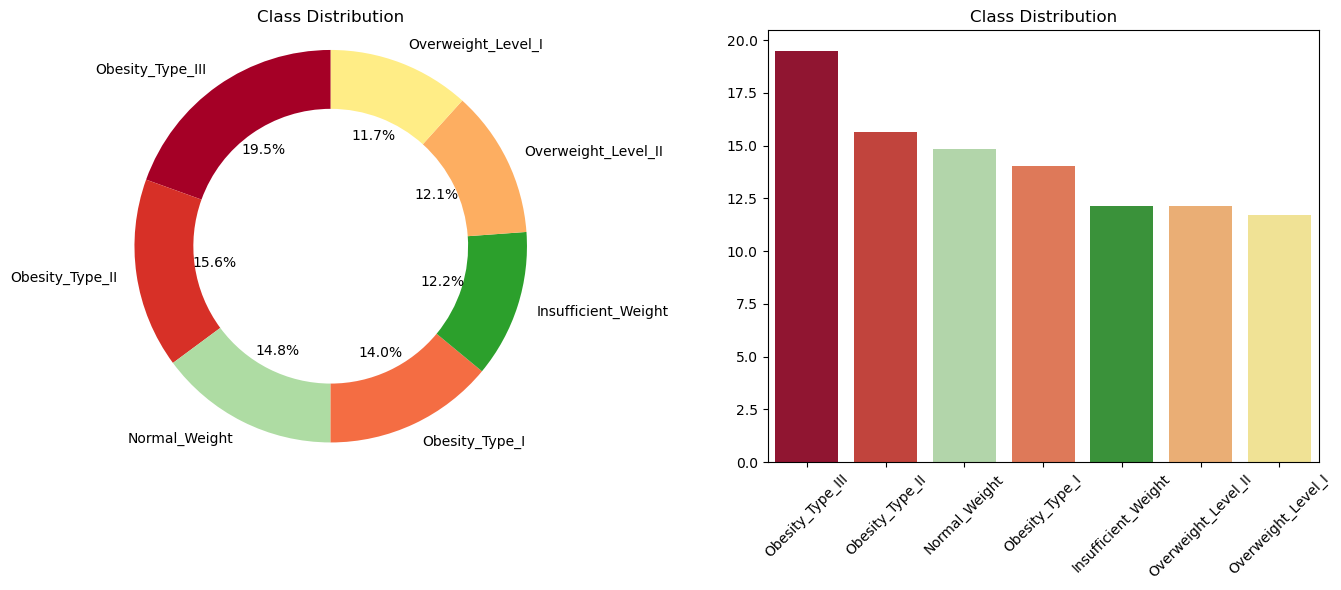

In [ ]:
# Define color palette with consistent colors for each class
color_palette = {
    'Insufficient_Weight': '#2ca02c',  # cooler - green
    'Normal_Weight': '#aedca3',  # light green
    'Overweight_Level_I': '#ffed86',  # yellow
    'Overweight_Level_II': '#fdae61',  # light orange
    'Obesity_Type_I': '#f46d43',  # orange
    'Obesity_Type_II': '#d73027',  # red-orange
    'Obesity_Type_III': '#a50026',  # warmer - deep red
}

# Set the figure size
plt.figure(figsize=(14, 6))

# Plot a donut chart
plt.subplot(1, 2, 1)
labels = unique_values_counts.index
sizes = unique_values_counts.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,  colors=[color_palette[class_] for class_ in labels], wedgeprops=dict(width=0.3))
plt.title('Class Distribution')
plt.axis('equal')

# Plot a countplot
#plt.subplot(1, 2, 2)
#sns.countplot(data=df_train, x=class_column, palette=[color_palette[class_] for class_ in labels], order=labels)
# Calculate percentages
value_counts = dataTrain[class_column].value_counts(normalize=True) * 100
percentages = [value_counts[label] for label in labels]

# Plotting
plt.subplot(1, 2, 2)
sns.barplot(x=labels, y=percentages, palette=[color_palette[class_] for class_ in labels])
plt.title('Class Distribution')
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

There is a slightly higher proportion of instances in the Obesity_Type_III class in the dataset, but overall, the classes are relatively balanced.

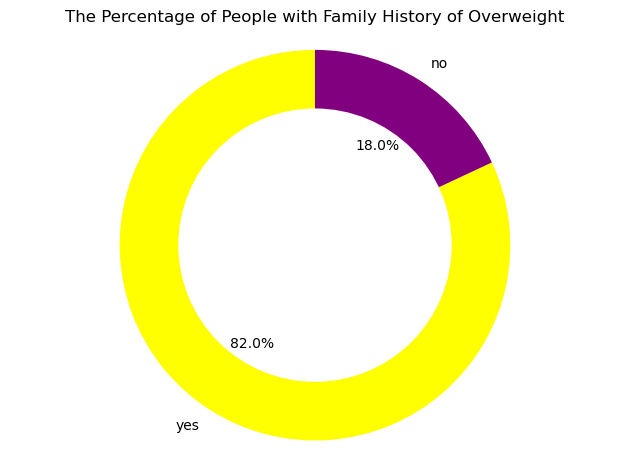

In [ ]:


# Count the occurrences of each category
category_counts = dataTrain['family_history_with_overweight'].value_counts()

# Plotting the donut chart
fig, ax = plt.subplots()
# Specify colors for the chart
colors = ['yellow', 'purple']

ax.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors = colors )
ax.add_artist(plt.Circle((0,0),0.70,fc='white'))

#Adding a title

plt.title('The Percentage of People with Family History of Overweight')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.tight_layout()
plt.show()


In the dataset, there are more people with family history overweight.

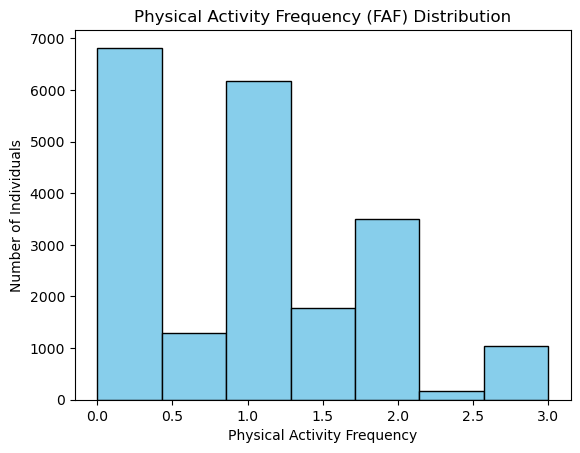

In [ ]:

# Plotting the histogram for the 'FAF' data from your DataFrame
plt.hist(dataTrain['FAF'], bins=7, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Physical Activity Frequency (FAF) Distribution')
plt.xlabel('Physical Activity Frequency')
plt.ylabel('Number of Individuals')
# Finally, show the plot
plt.show()

In the dataset, there are few people practicing physical activity (the majority is between 0 and 1)

In [ ]:

print(dataTrain[Numerical_columns].head())

          Age    Height      Weight      FCVC       NCP      CH2O       FAF  \
id                                                                            
0   24.443011  1.699998   81.669950  2.000000  2.983297  2.763573  0.000000   
1   18.000000  1.560000   57.000000  2.000000  3.000000  2.000000  1.000000   
2   18.000000  1.711460   50.165754  1.880534  1.411685  1.910378  0.866045   
3   20.952737  1.710730  131.274851  3.000000  3.000000  1.674061  1.467863   
4   31.641081  1.914186   93.798055  2.679664  1.971472  1.979848  1.967973   

         TUE        BMI  
id                       
0   0.976473  28.259565  
1   1.000000  23.422091  
2   1.673584  17.126706  
3   0.780199  44.855798  
4   0.931721  25.599151  


In [ ]:
print(dataTrain[categorical_columns].head())

    Gender family_history_with_overweight FAVC        CAEC SMOKE SCC  \
id                                                                     
0     Male                            yes  yes   Sometimes    no  no   
1   Female                            yes  yes  Frequently    no  no   
2   Female                            yes  yes   Sometimes    no  no   
3   Female                            yes  yes   Sometimes    no  no   
4     Male                            yes  yes   Sometimes    no  no   

         CALC                 MTRANS  
id                                    
0   Sometimes  Public_Transportation  
1          no             Automobile  
2          no  Public_Transportation  
3   Sometimes  Public_Transportation  
4   Sometimes  Public_Transportation  


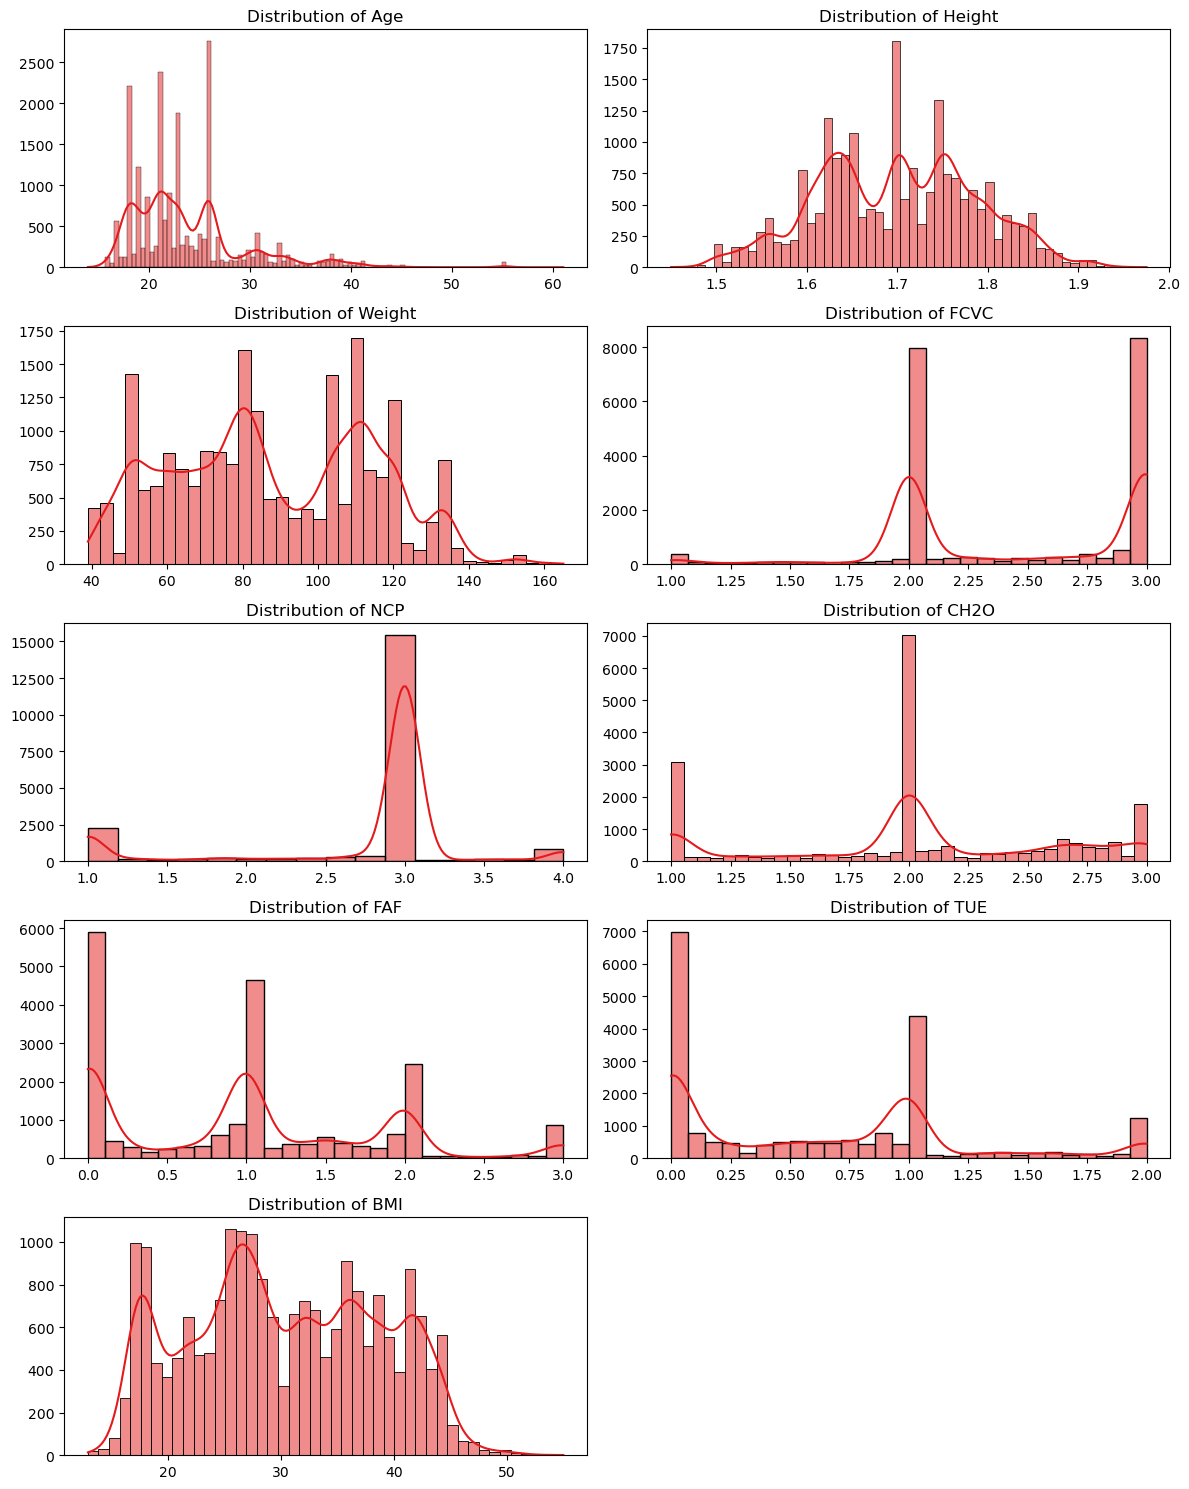

In [ ]:
# Get the list of numeric variables from the column names of numeric_df
variables = Numerical_columns

# Calculate the number of rows and columns for subplots
num_rows = (len(variables) - 1) // 2 + 1
num_cols = min(len(variables), 2)

sns.set_palette("Set1")

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows))
axes = axes.flatten()

# Loop through each variable and plot its distribution
for i, var in enumerate(variables):
    sns.histplot(data=dataTrain, x=var, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

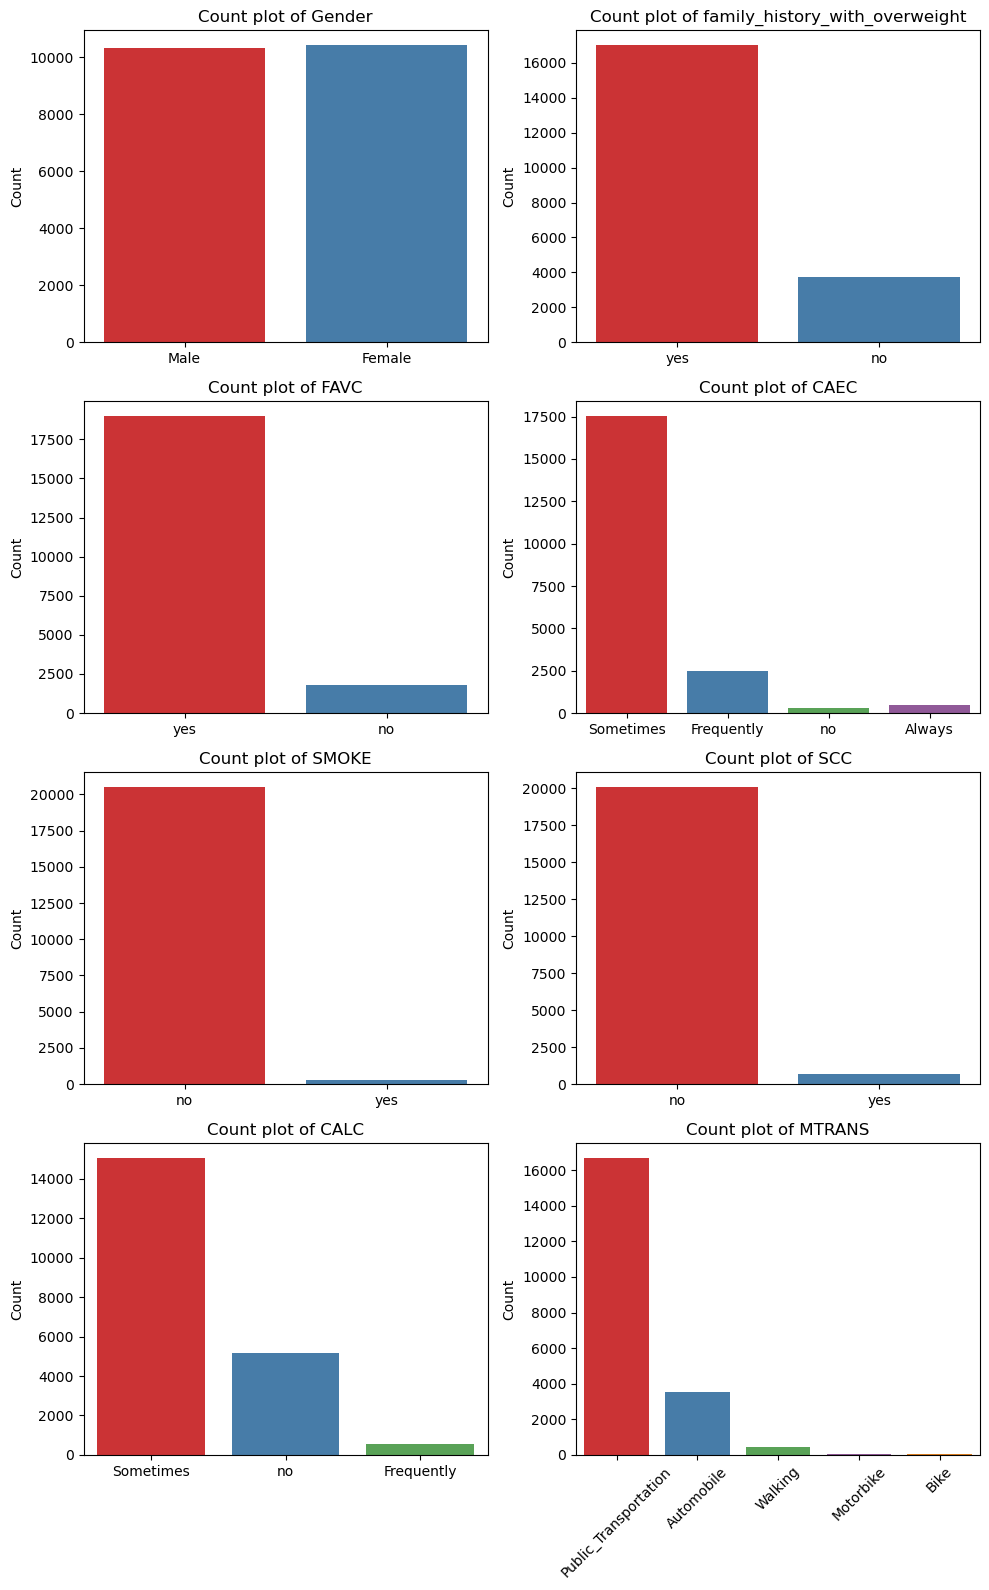

In [ ]:

num_rows_categorical = (len(categorical_columns) - 1) // 2 + 1
num_cols_categorical = min(len(categorical_columns), 2)

# Create a figure and axes for categorical variables
fig_categorical, axes_categorical = plt.subplots(num_rows_categorical, num_cols_categorical, figsize=(10, 4*num_rows_categorical))
axes_categorical = axes_categorical.flatten()

# Loop through each categorical variable and plot its count plot
for i, var in enumerate(categorical_columns):
    sns.countplot(data=dataTrain, x=var, ax=axes_categorical[i], palette="Set1")
    axes_categorical[i].set_title(f'Count plot of {var}')
    axes_categorical[i].set_xlabel('')
    axes_categorical[i].set_ylabel('Count')
    if var in ['MTRANS','NObeyesdad']:
        axes_categorical[i].set_xticklabels(axes_categorical[i].get_xticklabels(), rotation=45)


# Remove any unused subplots for categorical variables
for j in range(i+1, len(axes_categorical)):
    fig_categorical.delaxes(axes_categorical[j])

plt.tight_layout()
plt.show()

### Summary of the results

In the dataset:
- there are mainly equal balance of gender (men and women),

- there are more people with Family history with overweight

- few people are smoking (Smoke yes).

- few people are counting their Calories (SCC yes)

- most of the people are using Public Transportation (MTRANS)

- most of the people are eating between meals (CAEC sometimes, yes, frequently)

- most of the people consume a lot of high caloric food (FAVC yes)

- most of the people are sconsuming alcohol sometimes (CALC sometimes)

# Bivariate Analysis

C:\Users\nadia\AppData\Local\Temp\ipykernel_27808\2207643664.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Age', y='NObeyesdad', data=dataTrain, palette='Blues_d', order=df_mean_age.index,


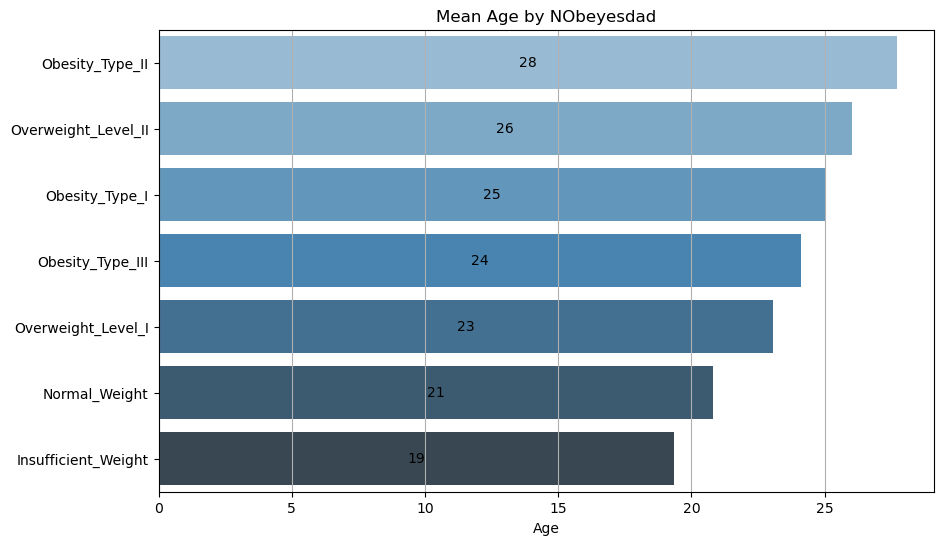

In [ ]:
# Mean Age by NObeyesdad

df_mean_age = dataTrain.groupby('NObeyesdad')['Age'].mean().round().astype(int).sort_values(ascending=False)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
ax = sns.barplot(x='Age', y='NObeyesdad', data=dataTrain, palette='Blues_d', order=df_mean_age.index,
                 estimator=np.mean, ci=None, errwidth=0)
for p, age in zip(ax.patches, df_mean_age.values):
    ax.annotate(f'{age}' if age % 1 != 0 else f'{int(age)}', (p.get_width() / 2, p.get_y() + p.get_height() / 2.),
                ha='center', va='center', xytext=(0, 0), textcoords='offset points', fontsize=10, color='black')
plt.title('Mean Age by NObeyesdad')
plt.xlabel('Age')
plt.ylabel('')
plt.grid(axis='x')  # Add gridlines along the x-axis
plt.show()

On average, individuals classified as 'Normal Weight' or 'Insufficient Weight' tend to be younger compared to other obesity categories.

C:\Users\nadia\AppData\Local\Temp\ipykernel_27808\2382292256.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=col, y='NObeyesdad', data=dataTrain, palette='Blues_d', order=df_mean.index,


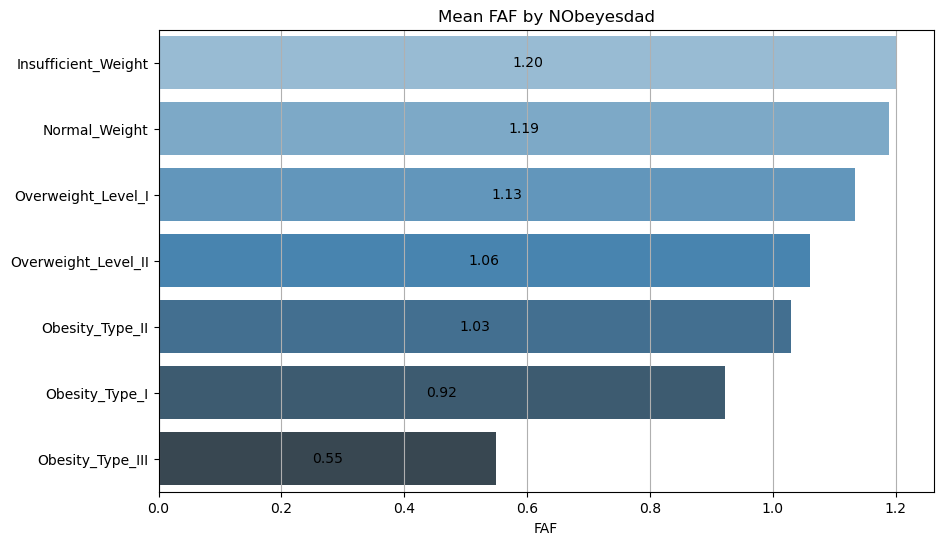

C:\Users\nadia\AppData\Local\Temp\ipykernel_27808\2382292256.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=col, y='NObeyesdad', data=dataTrain, palette='Blues_d', order=df_mean.index,


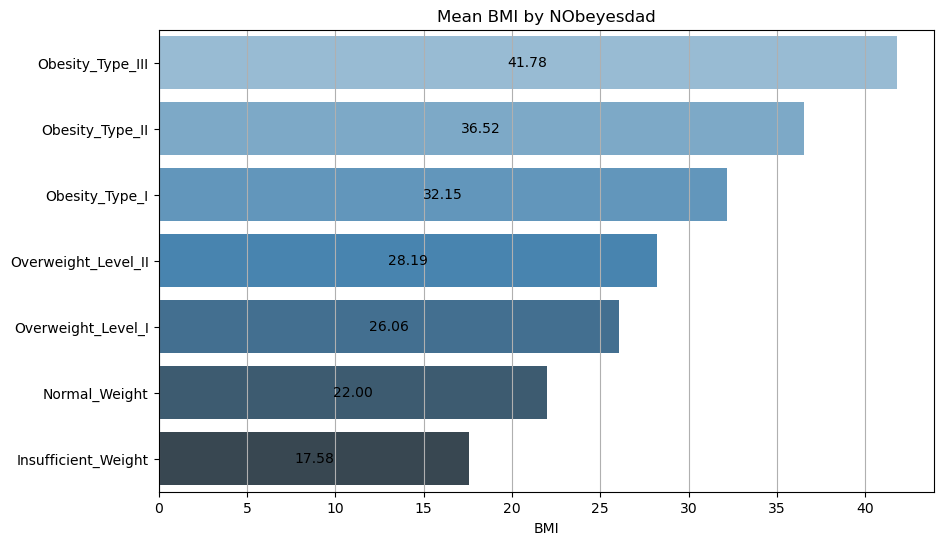

In [ ]:
# Displaying mean values for numeric columns

numeric_columns = ['FAF', 'BMI']
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    df_mean = dataTrain.groupby('NObeyesdad')[col].mean().sort_values(ascending=False)
    ax = sns.barplot(x=col, y='NObeyesdad', data=dataTrain, palette='Blues_d', order=df_mean.index,
                     estimator=np.mean, ci=None, errwidth=0)
    for p, val in zip(ax.patches, df_mean.values):
        ax.annotate(f'{val:.2f}', (p.get_width() / 2, p.get_y() + p.get_height() / 2.),
                    ha='center', va='center', xytext=(0, 0), textcoords='offset points', fontsize=10, color='black')
    plt.title(f'Mean {col} by NObeyesdad')
    plt.xlabel(col)
    plt.ylabel('')
    plt.grid(axis='x')
    plt.show()

Individuals with a FAF Phisical Activity Frequency from 0.55 and lower than that are categorized as 'Obesity_Type_III'
Individuals with a BMI lower than 18 are categorized as 'Underweight', those with a BMI between 18 and 22 are categorized as 'Normal', individuals with a BMI between 25 and 29.9 are categorized as 'Overweight', and those with a BMI of 30 or above are categorized as 'Obese'.

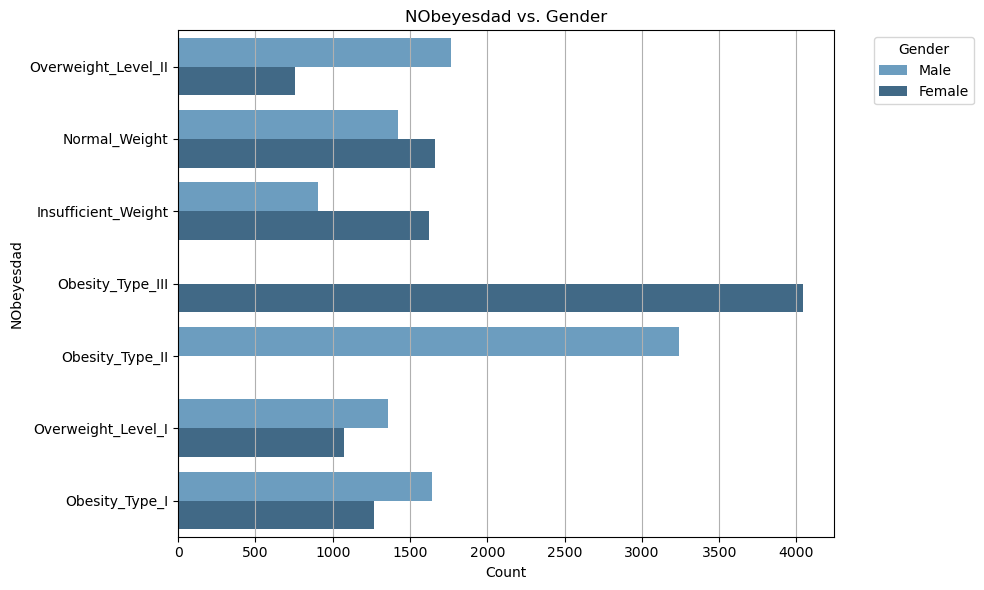

In [ ]:
# Bivariate analysis for Gender and NObeyesdad

plt.figure(figsize=(10, 6))
sns.countplot(y='NObeyesdad', hue='Gender', data=dataTrain, palette='Blues_d')
plt.title('NObeyesdad vs. Gender')
plt.xlabel('Count')
plt.ylabel('NObeyesdad')
plt.grid(axis='x')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In the category 'Obesity_Type_III', we observe only females. In the case of 'Obesity_Type_II', only males are prevalent. For 'Overweight_Level_I', 'Obesity_Type_I', and 'Overweight_Level_II', there is a tendency to have more males than females. Lastly, in the categories 'Normal_Weight' and 'Insufficient_Weight', there is a tendency to have more females than males.

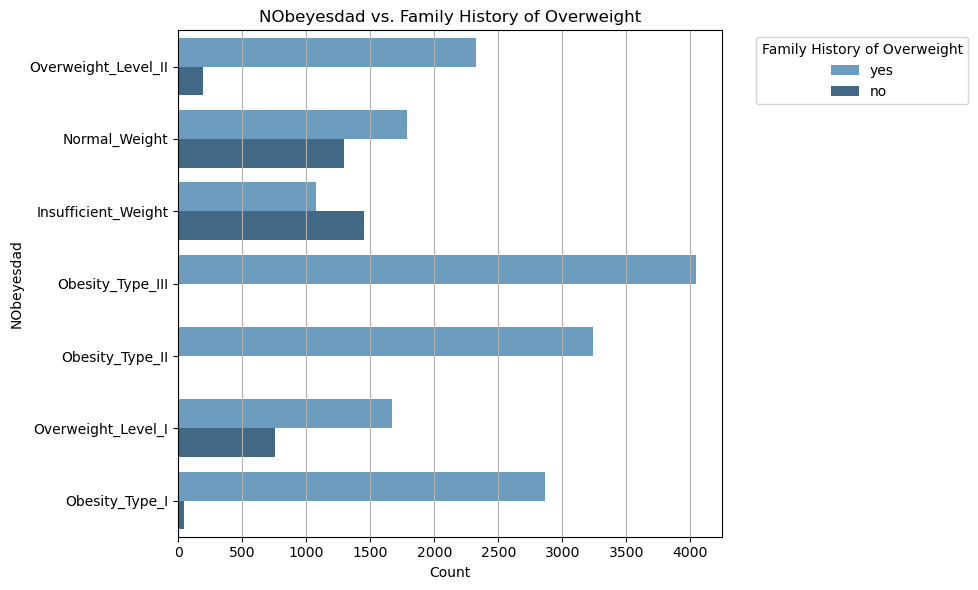

In [ ]:
# Bivariate analysis for family_history_with_overweight and NObeyesdad
plt.figure(figsize=(10, 6))
sns.countplot(y='NObeyesdad', hue='family_history_with_overweight', data=dataTrain, palette='Blues_d')
plt.title('NObeyesdad vs. Family History of Overweight')
plt.xlabel('Count')
plt.ylabel('NObeyesdad')
plt.grid(axis='x')
plt.legend(title='Family History of Overweight', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Individuals with a type of obesity 'Obesity_Type_III' and 'Obesity_Type_II' tend to be more highly related to Family History of overweight.

## Correlation Matrice

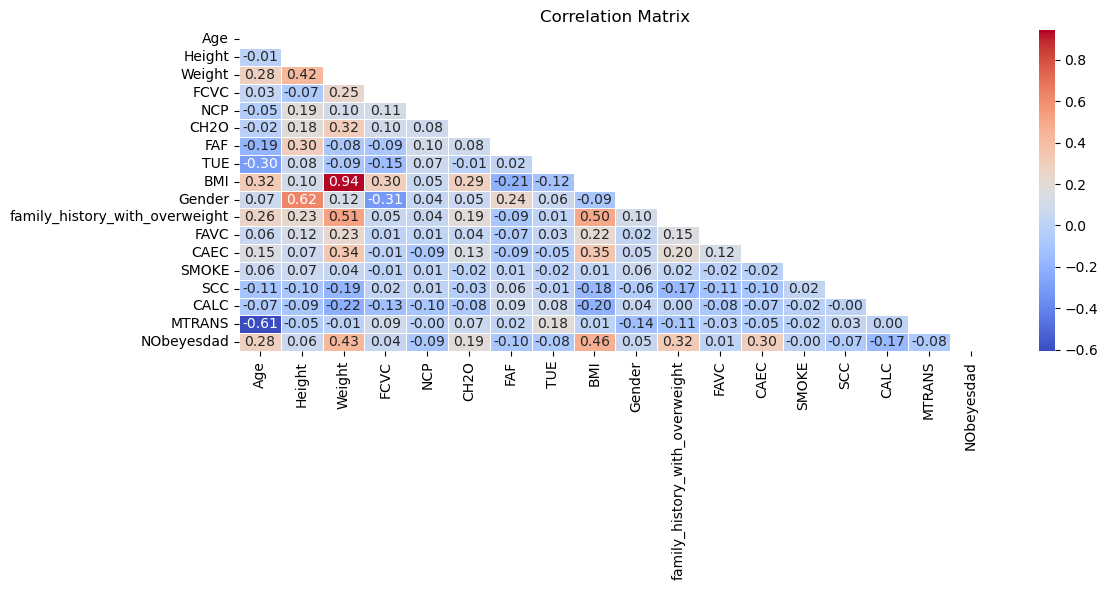

In [ ]:
numeric_df = dataTrain.select_dtypes(include='number')

# Select numerical columns
numeric_columns = numeric_df.columns

# Label encode categorical columns
label_encoded_df = dataTrain.select_dtypes(include=['object']).copy()
label_encoder = LabelEncoder()
for col in label_encoded_df.columns:
    label_encoded_df[col] = label_encoder.fit_transform(label_encoded_df[col])

# Concatenate numeric and label encoded categorical dataframes
combined_df = pd.concat([numeric_df, label_encoded_df], axis=1)

# Compute the correlation matrix
correlation_matrix = combined_df.corr()
upper_triangular_corr = correlation_matrix.where(np.tril(np.ones(correlation_matrix.shape), k=-1).astype(np.bool_))

# Create a figure and subplots
fig, axes = plt.subplots(figsize=(12, 6))

# Plot correlation matrix
sns.heatmap(upper_triangular_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes)
axes.set_title("Correlation Matrix")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


According to our correlation matrix, weight, BMI, family history of overweight, and CAEC (consumption of food between meals) exhibit strong correlations with the target variable. Furthermore, weight and BMI are highly correlated with each other. Hence, it is logical that both weight and BMI would demonstrate strong correlations with the target variable simultaneously.

# Model training using One-hot encoding and LGBM

## Encoding the data

In [ ]:
dataTrain.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
id,,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151


In [ ]:
train = pd.get_dummies(dataTrain, columns=categorical_columns, drop_first=True)


## Training the model using all parameters

In [ ]:
y = train['NObeyesdad']
X = train.drop('NObeyesdad', axis=1)
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train, y_train)

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes',
       'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2304
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 23
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightG

LGBMClassifier()

In [ ]:
y_pred = lgbm_classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9046242774566474

In [ ]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.93      0.94       524
      Normal_Weight       0.87      0.89      0.88       626
     Obesity_Type_I       0.89      0.87      0.88       543
    Obesity_Type_II       0.97      0.98      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.79      0.78      0.78       484
Overweight_Level_II       0.80      0.82      0.81       514

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



## Features importance

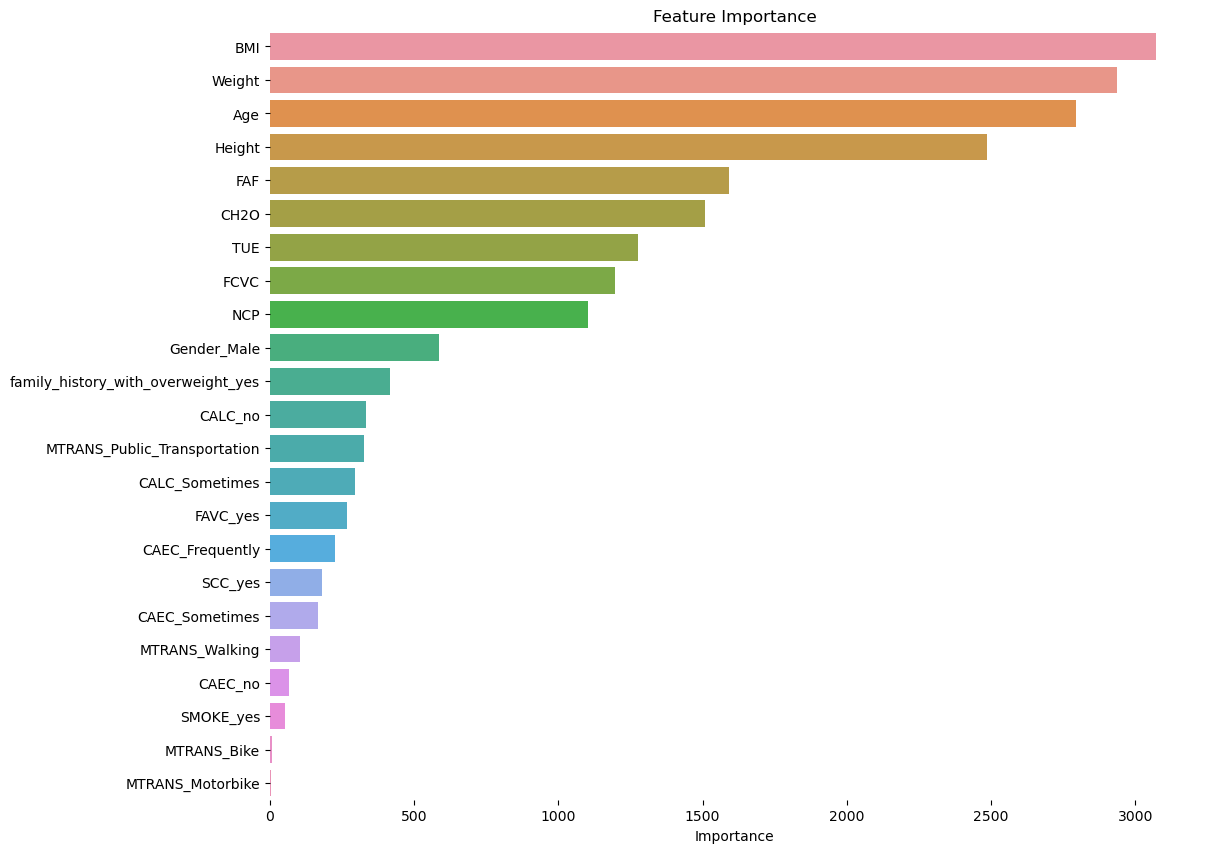

In [ ]:
feature_importance = lgbm_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

For the LGBM model with One-Hot enconding, the important features are BMI, Weight, and age. However, BMI and Weight are highly correlated. Let's conduct some experimentation by removing one of them.

## Training the model using all parameters except the BMI

In [ ]:
y = train['NObeyesdad']
X = train.drop(['NObeyesdad', 'BMI'], axis=1)
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train, y_train)

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes',
       'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 22
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [In

LGBMClassifier()

In [ ]:
y_pred = lgbm_classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9051059730250481

In [ ]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.93      0.94       524
      Normal_Weight       0.88      0.89      0.88       626
     Obesity_Type_I       0.88      0.87      0.88       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.78      0.79      0.79       484
Overweight_Level_II       0.80      0.82      0.81       514

           accuracy                           0.91      4152
          macro avg       0.90      0.89      0.90      4152
       weighted avg       0.91      0.91      0.91      4152



Overvall, there is a slight increase in the total accuracy (from 0.9046 to 0.9051), when removing the BMI column. However, the precision for the prediction of the classes Insufficient_Weight and Normal_Weight DECREASED.

## Training the model using all parameters except the Weight

In [ ]:
y = train['NObeyesdad']
X = train.drop(['NObeyesdad', 'Weight'], axis=1)
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train, y_train)

Index(['Age', 'Height', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes',
       'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 22
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info]

LGBMClassifier()

In [ ]:
y_pred = lgbm_classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.8995664739884393

In [ ]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.92      0.93       524
      Normal_Weight       0.88      0.88      0.88       626
     Obesity_Type_I       0.88      0.86      0.87       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.78      0.80      0.79       484
Overweight_Level_II       0.80      0.80      0.80       514

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



Even though weight is correlated with BMI and height, removing it drastically decreased the accuracy and precision of the model in predicting the classes.

## Training the model using all parameters except the calories counting information (SCC yes)

In [ ]:
y = train['NObeyesdad']
X = train.drop(['NObeyesdad', 'SCC_yes'], axis=1)
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train, y_train)

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',
       'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes',
       'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 22
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGB

LGBMClassifier()

In [ ]:
y_pred = lgbm_classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9005298651252408

In [ ]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.93      0.93       524
      Normal_Weight       0.87      0.88      0.87       626
     Obesity_Type_I       0.89      0.87      0.88       543
    Obesity_Type_II       0.98      0.97      0.98       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.78      0.77      0.78       484
Overweight_Level_II       0.79      0.80      0.80       514

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



Even if few people responded yes for counting their calories, removing this column significantly decreased the accuracy of the model and therefore, we can conclude that we should keep it.

## Conclusion:
We will use all the parameters for an overvall better learning of our model. The BMI helps to better detect certain types of obesity and the others (like SCC) are importants as well, even though their information seems to be imbalanced in the dataset

## Tuning the model using all the parameters

In [ ]:
train

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,BMI,...,CAEC_2,CAEC_3,SMOKE_1,SCC_1,CALC_1,CALC_2,MTRANS_1,MTRANS_2,MTRANS_3,MTRANS_4
id,,,,,,,,,,,,,,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Overweight_Level_II,28.259565,...,1,0,0,0,1,0,0,0,1,0
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,Normal_Weight,23.422091,...,0,0,0,0,0,1,0,0,0,0
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,Insufficient_Weight,17.126706,...,1,0,0,0,0,1,0,0,1,0
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Obesity_Type_III,44.855798,...,1,0,0,0,1,0,0,0,1,0
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Overweight_Level_II,25.599151,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,Obesity_Type_II,36.587084,...,1,0,0,0,1,0,0,0,1,0
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,Insufficient_Weight,17.099278,...,0,0,0,0,1,0,0,0,1,0
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,Obesity_Type_II,31.889841,...,1,0,0,0,0,1,0,0,1,0


In [ ]:
y = train['NObeyesdad']
X = train.drop('NObeyesdad', axis=1)

def objective(trial, X_train, y_train, X_test, y_test):
      # Define parameters to be optimized for the LGBMClassifier
      param = {
          "objective": "multiclass",
          "metric": "multi_logloss",
          "verbosity": -1,
          "boosting_type": "gbdt",
          "random_state": 42,
          "num_class": 7,
          "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2),
          "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
          "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
          "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
          "max_depth": trial.suggest_int("max_depth", 5, 20),
          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
          "subsample": trial.suggest_float("subsample", 0.8, 1.0),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
      }

  # LGBMClassifier with the suggested parameters
      lgbm_classifier = LGBMClassifier(**param)

 # Fit
      lgbm_classifier.fit(X_train, y_train)

 # Evaluate
      score = lgbm_classifier.score(X_test, y_test, )

      return score

 # Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 #sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

 # Create a study object
study = optuna.create_study(direction="maximize", sampler=sampler)

 # Run the optimization process
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)

 # best parameters after optimization
best_parameters_H = study.best_params

print('='*50)
print(best_parameters_H)

[I 2024-03-05 17:06:06,532] A new study created in memory with name: no-name-ee6ebd19-fe3b-47e2-ae7d-2306017b4e14
[I 2024-03-05 17:06:14,222] Trial 0 finished with value: 0.901252408477842 and parameters: {'learning_rate': 0.07553348365062514, 'n_estimators': 956, 'lambda_l1': 0.012319939418114049, 'lambda_l2': 0.04394633936788146, 'max_depth': 7, 'colsample_bytree': 0.3935967122017216, 'subsample': 0.8116167224336399, 'min_child_samples': 44}. Best is trial 0 with value: 0.901252408477842.
[I 2024-03-05 17:06:20,372] Trial 1 finished with value: 0.9014932562620424 and parameters: {'learning_rate': 0.12062188733689856, 'n_estimators': 737, 'lambda_l1': 0.005205844942958024, 'lambda_l2': 0.05879639408647977, 'max_depth': 18, 'colsample_bytree': 0.4274034664069657, 'subsample': 0.8363649934414201, 'min_child_samples': 13}. Best is trial 1 with value: 0.9014932562620424.
[I 2024-03-05 17:06:25,413] Trial 2 finished with value: 0.9046242774566474 and parameters: {'learning_rate': 0.0615442

[I 2024-03-05 17:08:04,322] Trial 21 finished with value: 0.9053468208092486 and parameters: {'learning_rate': 0.023523165404443346, 'n_estimators': 706, 'lambda_l1': 0.005355121675361037, 'lambda_l2': 0.05971532658308597, 'max_depth': 9, 'colsample_bytree': 0.7365223576070496, 'subsample': 0.8830864271678509, 'min_child_samples': 29}. Best is trial 7 with value: 0.9094412331406551.
[I 2024-03-05 17:08:10,981] Trial 22 finished with value: 0.9067919075144508 and parameters: {'learning_rate': 0.012840256423790887, 'n_estimators': 631, 'lambda_l1': 0.006170823531751922, 'lambda_l2': 0.054760775634552075, 'max_depth': 10, 'colsample_bytree': 0.7321412356749988, 'subsample': 0.8502220728783726, 'min_child_samples': 37}. Best is trial 7 with value: 0.9094412331406551.
[I 2024-03-05 17:08:16,238] Trial 23 finished with value: 0.9094412331406551 and parameters: {'learning_rate': 0.03793531537186375, 'n_estimators': 508, 'lambda_l1': 0.00516160800630294, 'lambda_l2': 0.05543699379303314, 'max_

[I 2024-03-05 17:10:00,508] Trial 43 finished with value: 0.9060693641618497 and parameters: {'learning_rate': 0.005483035326459671, 'n_estimators': 598, 'lambda_l1': 0.013119887152270793, 'lambda_l2': 0.039419163055289336, 'max_depth': 12, 'colsample_bytree': 0.47743333928913134, 'subsample': 0.8980955851683428, 'min_child_samples': 24}. Best is trial 7 with value: 0.9094412331406551.
[I 2024-03-05 17:10:05,695] Trial 44 finished with value: 0.8973988439306358 and parameters: {'learning_rate': 0.1994917563924749, 'n_estimators': 577, 'lambda_l1': 0.014086097426310801, 'lambda_l2': 0.051843759886376795, 'max_depth': 11, 'colsample_bytree': 0.608249548722261, 'subsample': 0.8739078096150505, 'min_child_samples': 11}. Best is trial 7 with value: 0.9094412331406551.
[I 2024-03-05 17:10:10,828] Trial 45 finished with value: 0.9072736030828517 and parameters: {'learning_rate': 0.024487654132843078, 'n_estimators': 424, 'lambda_l1': 0.00605903772174825, 'lambda_l2': 0.056596684800161806, 'ma

{'learning_rate': 0.01861000790833198, 'n_estimators': 276, 'lambda_l1': 0.005452272889105381, 'lambda_l2': 0.03301321323053057, 'max_depth': 11, 'colsample_bytree': 0.4628094190643376, 'subsample': 0.9657475018303858, 'min_child_samples': 21}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lgbm_classifier = LGBMClassifier(**best_parameters_H)
lgbm_classifier.fit(X_train, y_train)

y_pred = lgbm_classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0.005452272889105381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005452272889105381
[LightGBM] [Warning] lambda_l2 is set=0.03301321323053057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03301321323053057
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.005452272889105381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005452272889105381
[LightGBM] [Warning] lambda_l2 is set=0.03301321323053057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03301321323053057
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230

This study led us to a model of LGBM using all the parameters One-hot encoded and it got an overvall accuracy score of 0.9060693641618497 after tuning

# Model training using Label encoding and LGBM

In [ ]:
categorical_columns

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

## Label encoding the data

In [ ]:
# encoding using label

# Initialize LabelEncoder
label_encoders = ()


df= dataTrain

# Iterate over each column with categorical variables
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
id,,,,,,,,,,,,,,,,,,
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,2,0,2.763573,0,0.000000,0.976473,1,3,Overweight_Level_II,28.259565
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,1,0,2.000000,0,1.000000,1.000000,2,0,Normal_Weight,23.422091
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,2,0,1.910378,0,0.866045,1.673584,2,3,Insufficient_Weight,17.126706
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,2,0,1.674061,0,1.467863,0.780199,1,3,Obesity_Type_III,44.855798
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,2,0,1.979848,0,1.967973,0.931721,1,3,Overweight_Level_II,25.599151


## Training the model using label encoding and all the parameters

In this study, we will consider all the parameters directly

In [ ]:
y = df['NObeyesdad']
X = df.drop('NObeyesdad', axis=1)
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train, y_train)

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'BMI'],
      dtype='object')
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 17
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625


LGBMClassifier()

In [ ]:
y_pred = lgbm_classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9019749518304432

In [ ]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.93      0.94       524
      Normal_Weight       0.88      0.89      0.89       626
     Obesity_Type_I       0.88      0.87      0.87       543
    Obesity_Type_II       0.98      0.98      0.98       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.77      0.78      0.78       484
Overweight_Level_II       0.79      0.79      0.79       514

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



Without tuning, the model using label encoding, got us an accuracy of 0.9019, which is low than the one we got before tuning the One-hot encoding model

## Tuning the model with label encoding

In [ ]:
y

id
0        Overweight_Level_II
1              Normal_Weight
2        Insufficient_Weight
3           Obesity_Type_III
4        Overweight_Level_II
                ...         
20753        Obesity_Type_II
20754    Insufficient_Weight
20755        Obesity_Type_II
20756    Overweight_Level_II
20757        Obesity_Type_II
Name: NObeyesdad, Length: 20758, dtype: object

In [ ]:

def objective(trial, X_train, y_train, X_test, y_test):
      # Define parameters to be optimized for the LGBMClassifier
      param = {
          "objective": "multiclass",
          "metric": "multi_logloss",
          "verbosity": -1,
          "boosting_type": "gbdt",
          "random_state": 42,
          "num_class": 7,
          "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2),
          "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
          "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
          "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
          "max_depth": trial.suggest_int("max_depth", 5, 20),
          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
          "subsample": trial.suggest_float("subsample", 0.8, 1.0),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
      }

  # LGBMClassifier with the suggested parameters
      lgbm_classifier = LGBMClassifier(**param)

 # Fit
      lgbm_classifier.fit(X_train, y_train)

 # Evaluate
      score = lgbm_classifier.score(X_test, y_test, )

      return score

 # Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 #sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

 # Create a study object
study = optuna.create_study(direction="maximize", sampler=sampler)

 # Run the optimization process
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)

 # best parameters after optimization
best_parameters = study.best_params

print('='*50)
print(best_parameters)

[I 2024-03-12 11:33:36,574] A new study created in memory with name: no-name-97a2e6b9-942c-4d3a-b7cf-061f89b6e585
[I 2024-03-12 11:33:43,439] Trial 0 finished with value: 0.9022157996146436 and parameters: {'learning_rate': 0.07553348365062514, 'n_estimators': 956, 'lambda_l1': 0.012319939418114049, 'lambda_l2': 0.04394633936788146, 'max_depth': 7, 'colsample_bytree': 0.3935967122017216, 'subsample': 0.8116167224336399, 'min_child_samples': 44}. Best is trial 0 with value: 0.9022157996146436.
[I 2024-03-12 11:33:48,922] Trial 1 finished with value: 0.9002890173410405 and parameters: {'learning_rate': 0.12062188733689856, 'n_estimators': 737, 'lambda_l1': 0.005205844942958024, 'lambda_l2': 0.05879639408647977, 'max_depth': 18, 'colsample_bytree': 0.4274034664069657, 'subsample': 0.8363649934414201, 'min_child_samples': 13}. Best is trial 0 with value: 0.9022157996146436.
[I 2024-03-12 11:33:52,875] Trial 2 finished with value: 0.905587668593449 and parameters: {'learning_rate': 0.061544

[I 2024-03-12 11:36:43,249] Trial 21 finished with value: 0.9072736030828517 and parameters: {'learning_rate': 0.02200621210411965, 'n_estimators': 352, 'lambda_l1': 0.013181320251884409, 'lambda_l2': 0.04282838106413997, 'max_depth': 9, 'colsample_bytree': 0.48911047719620393, 'subsample': 0.940102714181844, 'min_child_samples': 25}. Best is trial 14 with value: 0.9099229287090559.
[I 2024-03-12 11:36:53,305] Trial 22 finished with value: 0.9084778420038536 and parameters: {'learning_rate': 0.03237299347286805, 'n_estimators': 469, 'lambda_l1': 0.007153369176152692, 'lambda_l2': 0.02995779135100955, 'max_depth': 8, 'colsample_bytree': 0.42277600075194965, 'subsample': 0.9748303281684237, 'min_child_samples': 5}. Best is trial 14 with value: 0.9099229287090559.
[I 2024-03-12 11:37:02,495] Trial 23 finished with value: 0.9084778420038536 and parameters: {'learning_rate': 0.01163134662217689, 'n_estimators': 675, 'lambda_l1': 0.013546371466153916, 'lambda_l2': 0.024621048152350125, 'max_

[I 2024-03-12 11:40:12,750] Trial 43 finished with value: 0.9063102119460501 and parameters: {'learning_rate': 0.011844277364333085, 'n_estimators': 532, 'lambda_l1': 0.014185480346495383, 'lambda_l2': 0.024322268802984624, 'max_depth': 7, 'colsample_bytree': 0.30490002579860365, 'subsample': 0.8742930609986815, 'min_child_samples': 49}. Best is trial 39 with value: 0.9104046242774566.
[I 2024-03-12 11:40:21,518] Trial 44 finished with value: 0.9096820809248555 and parameters: {'learning_rate': 0.03634158477426855, 'n_estimators': 448, 'lambda_l1': 0.012607196756009345, 'lambda_l2': 0.021804930351177875, 'max_depth': 10, 'colsample_bytree': 0.357506616335763, 'subsample': 0.8972093310088292, 'min_child_samples': 30}. Best is trial 39 with value: 0.9104046242774566.
[I 2024-03-12 11:40:30,873] Trial 45 finished with value: 0.9079961464354528 and parameters: {'learning_rate': 0.04016737350944519, 'n_estimators': 451, 'lambda_l1': 0.012397055435457868, 'lambda_l2': 0.02160971465515272, 'm

{'learning_rate': 0.029360941280932137, 'n_estimators': 512, 'lambda_l1': 0.012912879986094793, 'lambda_l2': 0.03144935519184769, 'max_depth': 13, 'colsample_bytree': 0.3234407387824524, 'subsample': 0.8706657559633919, 'min_child_samples': 42}


In [ ]:
best_parameters= {'learning_rate': 0.029360941280932137, 'n_estimators': 512, 'lambda_l1': 0.012912879986094793, 'lambda_l2': 0.03144935519184769, 'max_depth': 13, 'colsample_bytree': 0.3234407387824524, 'subsample': 0.8706657559633919, 'min_child_samples': 42}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lgbm_classifier = LGBMClassifier(**best_parameters)
lgbm_classifier.fit(X_train, y_train)

y_pred = lgbm_classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0.012912879986094793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012912879986094793
[LightGBM] [Warning] lambda_l2 is set=0.03144935519184769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03144935519184769
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l1 is set=0.012912879986094793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012912879986094793
[LightGBM] [Warning] lambda_l2 is set=0.03144935519184769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03144935519184769
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] lambda_l1 is set=0.012912879986094793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012912879986094793
[LightGBM] [Warning] lambda_l2 is set=0.03144935519184769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03144935519184769
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.9101637764932563
                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.94      0.94       524
      Normal_Weight       0.89      0.90      0.90       626
     Obesity_Type_I       0.88      0.87      0.88       543
    Obesity_Type_II       0.98      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.80      0.80      0.80       484
Overweight_Level_II       0.81      0.82      0.81       514

           accuracy                           0.91      4152
          macro avg       0

## Features importance in the tuned LGBM model

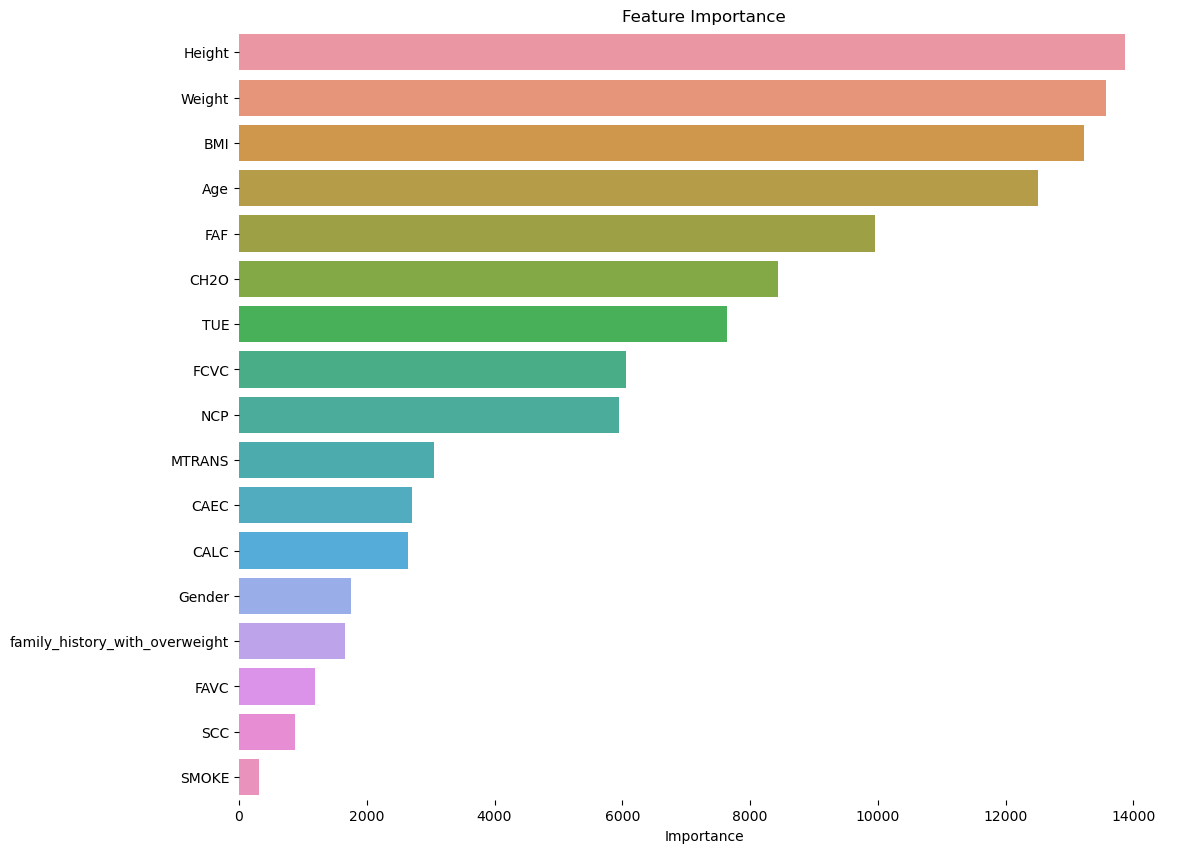

In [ ]:
feature_importance = lgbm_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

For the LGBM Model with label encoding, the Height, the Weight and the BMI are the most important features

## Confusion Matrix of tuned LGBM model

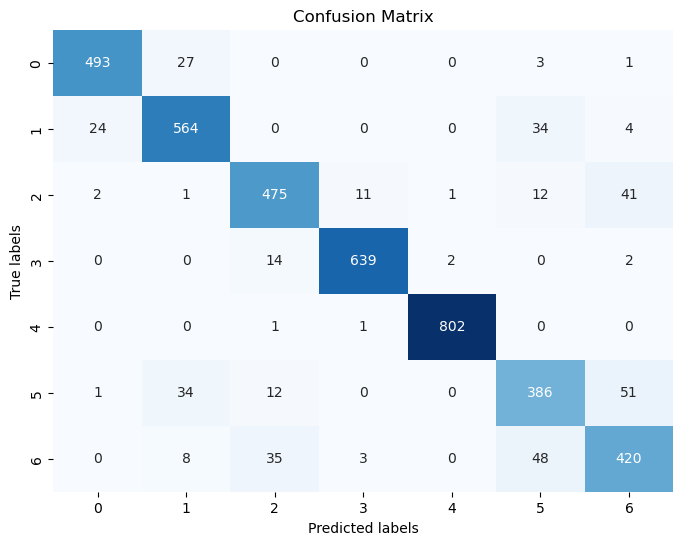

In [ ]:

# Confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


### The labels are followed :

- 0= Insufficient_Weight
- 1= Normal_Weight
- 2= Obesity_Type_I
- 3= Obesity_Type_II
- 4= Obesity_Type_III
- 5= Overweight_Level_I
- 6= Overweight_Level_II

 The Obesity_Type_II and Obesity_Type_III are well predicted by our model, overwall.

 The model is having issue with labeling Overweight_Level_I and Overweight_Level_II and Obesity_Type_I

# Conclusion
The tuned model, using label encoding, helped us achieve better accuracy compared to the model using one-hot encoding. However, it's worth noting that this result might be influenced by our computing environment, and it may not generalize to all classification problems. While the use of LGBM and label encoding contributed to achieving an accuracy of 0.9101637764932563, our best result thus far in the study, further exploration and validation are required to determine the most effective solution for prediction in this context.

# Model training using Label encoding and Random Forest

In [ ]:
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
id,,,,,,,,,,,,,,,,,,
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,2,0,2.763573,0,0.000000,0.976473,1,3,Overweight_Level_II,28.259565
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,1,0,2.000000,0,1.000000,1.000000,2,0,Normal_Weight,23.422091
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,2,0,1.910378,0,0.866045,1.673584,2,3,Insufficient_Weight,17.126706
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,2,0,1.674061,0,1.467863,0.780199,1,3,Obesity_Type_III,44.855798
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,2,0,1.979848,0,1.967973,0.931721,1,3,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,1,25.137087,1.766626,114.187096,1,1,2.919584,3.000000,2,0,2.151809,0,1.330519,0.196680,1,3,Obesity_Type_II,36.587084
20754,1,18.000000,1.710000,50.000000,0,1,3.000000,4.000000,1,0,1.000000,0,2.000000,1.000000,1,3,Insufficient_Weight,17.099278
20755,1,20.101026,1.819557,105.580491,1,1,2.407817,3.000000,2,0,2.000000,0,1.158040,1.198439,2,3,Obesity_Type_II,31.889841


## Determination of the best parameters

In [ ]:

y = df['NObeyesdad']
X = df.drop('NObeyesdad', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


# Define parameter grid to test on different sets to find the best parameters
param_grid = {
    'n_estimators': [150, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [15,20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_imputed, y_train)

best_params_rf = grid_search.best_params_
print(best_params_rf)

C:\Users\nadia\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nadia\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nadia\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\nadia\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\nadia\anaconda3\Lib\site-packag

{'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}


In [ ]:
best_params_rf

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

## Tuned Random Forest model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

rf = RandomForestClassifier(**best_params_rf, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9005298651252408
                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.93      0.93       524
      Normal_Weight       0.86      0.88      0.87       626
     Obesity_Type_I       0.88      0.87      0.88       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804
 Overweight_Level_I       0.77      0.77      0.77       484
Overweight_Level_II       0.81      0.80      0.80       514

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



## Features importance in the RF model

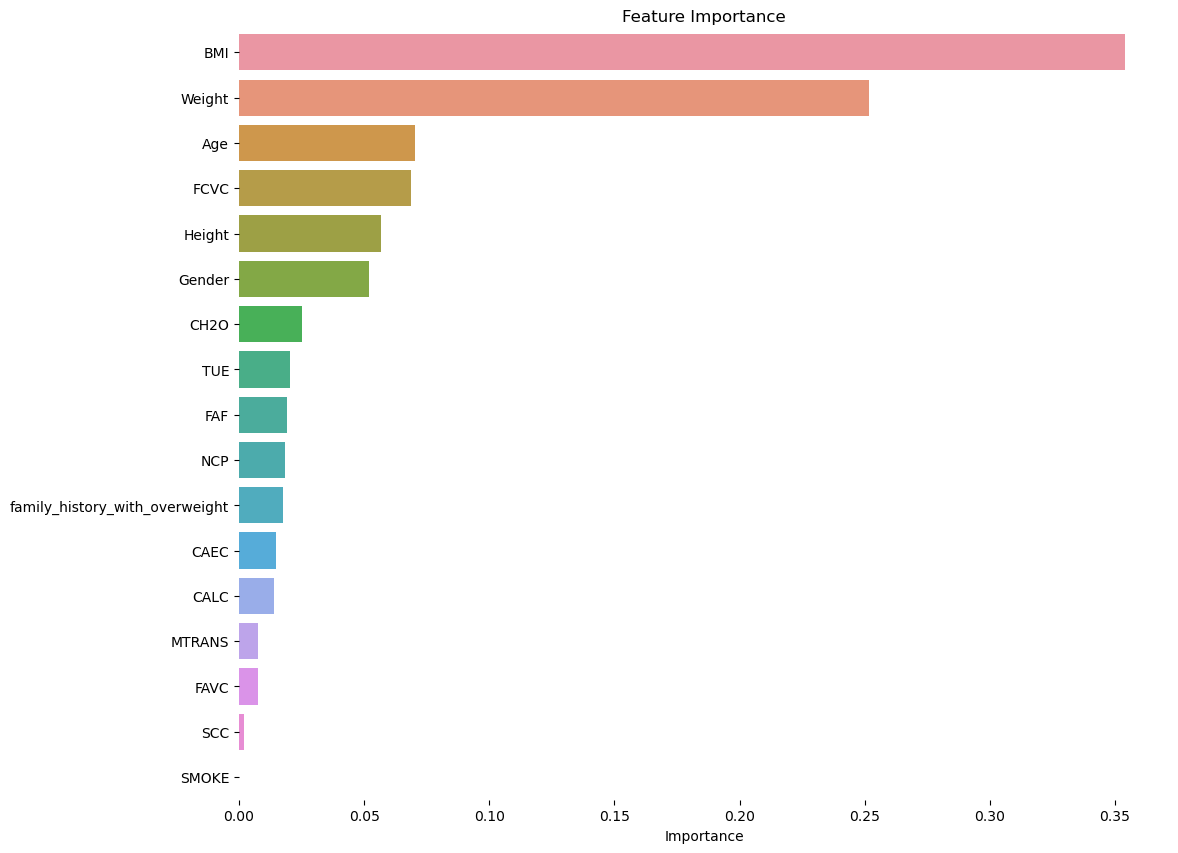

In [ ]:
feature_importance = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

For the Random Forest model, the BMI and Weight and age are the most important features for the model

> Indented block



## Confusion Matrix of RF model

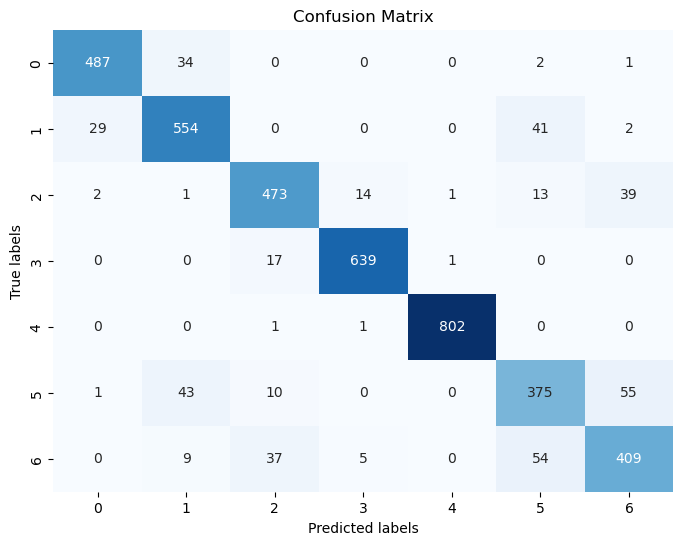

In [ ]:

# Confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


The labels are followed :
- 0= Insufficient_Weight
- 1= Normal_Weight
- 2= Obesity_Type_I
- 3= Obesity_Type_II
- 4= Obesity_Type_III
- 5= Overweight_Level_I
- 6= Overweight_Level_II

Like the LGBM model, the Random forest model predict well The Obesity_Type_II and Obesity_Type_III, overwall.

The RF model is having issue with labeling Overweight_Level_I and Overweight_Level_II and Obesity_Type_I and Insufficient_Weight

# Conclusion
Tuning the Random Forest model did not yield improved results compared to those achieved with the LGBM. Consequently, we will proceed with submitting our code featuring the LGBM boosting model utilizing label encoding.

## Submission

In [ ]:
dataTest

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI
id,,,,,,,,,,,,,,,,,
20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation,35.315411
20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation,25.781250
20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation,41.324115
20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation,42.976937
20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation,39.584143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34593,Male,23.327836,1.721384,78.030383,yes,no,2.813234,3.000000,Sometimes,no,1.000000,no,0.807076,0.778632,Sometimes,Public_Transportation,26.333478
34594,Female,29.000000,1.590000,62.000000,no,yes,3.000000,3.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,24.524346
34595,Female,22.935612,1.585547,44.376637,no,yes,3.000000,2.273740,Frequently,no,2.000000,no,1.949840,1.000000,Sometimes,Public_Transportation,17.652091


## Label encoding the dataset Test

In [ ]:
# Initialize LabelEncoder
label_encoders = ()

test= dataTest

# Iterate over each column with categorical variables
for col in categorical_columns:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col])

test.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI
id,,,,,,,,,,,,,,,,,
20758,1,26.899886,1.848294,120.644178,1,1,2.938616,3.000000,2,0,2.825629,0,0.855400,0.000000,2,3,35.315411
20759,0,21.000000,1.600000,66.000000,1,1,2.000000,1.000000,2,0,3.000000,0,1.000000,0.000000,2,3,25.781250
20760,0,26.000000,1.643355,111.600553,1,1,3.000000,3.000000,2,0,2.621877,0,0.000000,0.250502,2,3,41.324115
20761,1,20.979254,1.553127,103.669116,1,1,2.000000,2.977909,2,0,2.786417,0,0.094851,0.000000,2,3,42.976937
20762,0,26.000000,1.627396,104.835346,1,1,3.000000,3.000000,2,0,2.653531,0,0.000000,0.741069,2,3,39.584143


## Predictions and creation of the csv submission file

In [ ]:

# Evaluate the best model on the test set
predictions = lgbm_classifier.predict(test)

submission = pd.read_csv("C:/Users/nadia/Downloads/kaggle challenge/sample_submission.csv")
submission["NObeyesdad"] = predictions

submission.to_csv("submission1.csv", index=False)
submission.head()

[LightGBM] [Warning] lambda_l1 is set=0.012912879986094793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012912879986094793
[LightGBM] [Warning] lambda_l2 is set=0.03144935519184769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03144935519184769
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
